# Block Resampling & Z Scores

This code takes in raw climate data from [Met Eireann](http://www.met.ie/climate-request/) then 
- Computes [Potential Evapotranspiration](https://en.wikipedia.org/wiki/Potential_evaporation) according to the Hargreaves method (chosen due to data availability) 
- Splits the data into seasons according to the climatological year (Winter: DJF, Spring: MAM, Summer: JJA, Autumn: SON)
- Removes seasons which has missing values above a certain threshold
- Calculates temperature and rainfall extremes based on z-scores and standard deviations respectively
- Allows for the selection of certain seasonal characteristics (warm/wet, warm/dry, cold/wet, cold/dry)
- Resamples the observed climate and produces a new sequence which takes extremes into account

### To Do List

1. Generate extreme indices for seasons (warm season, cool season, wet season, dry season)
2. Generate new sequence based on multiple warm years, cool years, wet years, dry years etc. 

### User-Defined Variables (to be coded in if possible)

In [1]:
outputyears = 50 #number of years in your generated sequence

### Load Necessary Packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pyeto #install from here (https://github.com/woodcrafty/PyETo), download zip, move to scripts folder in your python
#distribution (/Anaconda/Scripts/PyETo), navigate to this folder in your cmd, type: python setup.py install, restart python
from pyeto import hargreaves
%matplotlib inline

### Read in & display climate data

- maxtp: -  Maximum Air Temperature (C)
- mintp: -  Minimum  Air Temperature (C)
- rain: -	  Precipitation Amount (mm)
- cbl:  -   Mean CBL Pressure (hpa) (CBL - convective boundary layer)
- wdsp: -	  Mean Wind Speed (knot)
- hm: -	  Highest ten minute mean wind speed (knot)		                 
- ddhm: -	  Mean Wind Direction over 10 minutes at time of highest 10 minute mean (degree)                  
- hg: -	  Highest Gust (knot)
- soil  -   Mean 10cm soil temperature (C)
- i: -	  Indicator

In [3]:
df = pd.read_csv("E:\PhD\Data\MetData\Raw\dly375 (Oak Park)\dly375.csv",skiprows=16, na_values=[' '])
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,hm,iddhm,ddhm,ihg,hg,soil
0,01-jan-2007,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,23,0,250,0,33,4.071
1,02-jan-2007,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,21,0,240,0,33,4.304
2,03-jan-2007,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,25,0,250,0,38,7.723
3,04-jan-2007,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,23,0,260,0,35,6.758
4,05-jan-2007,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,14,0,260,0,19,6.760


Convert 'date' column to datetime object

In [4]:
df['date'] = pd.to_datetime(df['date'], format= '%d-%b-%Y') # https://docs.python.org/2/library/datetime.html see end of this page for %d %m %Y

Find start and end year of the data

In [5]:
no_of_years = df['date'].dt.year #creates a variable for the year column
no_of_years = list(no_of_years) #turns it into a list

In [6]:
startyear = no_of_years[0] #gets the first value
print startyear

endyear = no_of_years[-1] #gets the last value
print endyear

2007
2015


### Create mean temp field

In [7]:
df['meantp'] = (df['maxtp'] + df['mintp'])/2
df.meantp = df.meantp.round(1) #keep Tmean to one decimal place as that's what's in the original dat
#NOTE:Numpy rounds to the nearest even value. Thus 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0, etc.

### Calculate PET using [Hargreaves method](https://github.com/woodcrafty/PyETo/blob/master/docs/hargreaves.rst) (from [PyETo package](https://github.com/woodcrafty/PyETo))

The hargreaves method is recommended by the FAO (Allen et al, 1998) where insufficient meterological data are available from Penman-Monteith)

It uses temperature and solar radiation which is estimated from the latitude and the time of year.

The Hargreaves equation has a tendency to under-estimate ETo under high wind conditions(u2 > 3m/s) and to over-estimate under conditions of high relative humidity.

**First specify latitude for your site, and create a 'day of year' column from the date:**

In [8]:
lat = pyeto.deg2rad(52.861) #latitude for Oak Park Carlow

df['lat']= lat #add column to the dataframe

df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear #create 'day of year' column to calculate sunshine variables

Estimate solar declination (sol_dec), sunset hour angle (sha), inverse relative distance from Earth to the sun (ird), and ET radiation (et_rad)

In [9]:
sol_dec = df['dayofyear'].apply(pyeto.sol_dec)   # Solar declination
df['sol_dec'] = sol_dec #add column

sha = df.apply(lambda x: pyeto.sunset_hour_angle(x['lat'],x['sol_dec']), axis=1)
df['sha'] = sha #add column

ird = df['dayofyear'].apply(pyeto.inv_rel_dist_earth_sun)
df['ird'] = ird

et_rad = df.apply(lambda x: pyeto.et_rad(x['lat'],x['sol_dec'],x['sha'],x['ird']), axis =1)   # Extraterrestrial radiation
df['et_rad'] = et_rad

df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,ihg,hg,soil,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad
0,2007-01-01,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,...,0,33,4.071,4.8,0.922598,1,-0.401008,0.976637,1.032995,6.083577
1,2007-01-02,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,...,0,33,4.304,7.1,0.922598,2,-0.399564,0.979348,1.032980,6.134697
2,2007-01-03,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,...,0,38,7.723,10.1,0.922598,3,-0.398001,0.982272,1.032956,6.190089
3,2007-01-04,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,...,0,35,6.758,8.5,0.922598,4,-0.396320,0.985406,1.032922,6.249764
4,2007-01-05,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,...,0,19,6.760,7.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735


Apply the 'hargreaves' function

In [10]:
PEcalc = df.apply(lambda x: hargreaves(x['mintp'], x['maxtp'], x['meantp'], x['et_rad']),axis=1)
df['hargreaves'] = PEcalc #create a column
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,hg,soil,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad,hargreaves
0,2007-01-01,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,...,33,4.071,4.8,0.922598,1,-0.401008,0.976637,1.032995,6.083577,0.203998
1,2007-01-02,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,...,33,4.304,7.1,0.922598,2,-0.399564,0.979348,1.032980,6.134697,0.307439
2,2007-01-03,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,...,38,7.723,10.1,0.922598,3,-0.398001,0.982272,1.032956,6.190089,0.324130
3,2007-01-04,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,...,35,6.758,8.5,0.922598,4,-0.396320,0.985406,1.032922,6.249764,0.238953
4,2007-01-05,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,...,19,6.760,7.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735,0.350152


Compare hargreaves calculation to Met Eireann PE (Penman-Monteith method) (purely to see if the calculation approximates)

In [11]:
metPE = pd.read_excel("E:\PhD\Data\MetData\PE\OakPark 08-16.xlsx")
metPE['date'] = pd.to_datetime(metPE['date'], format= '%d-%b-%Y') #datetime object
metPE = metPE[['date','PE (mm)']]
metPE.head()

,date,PE (mm)
0,2008-01-01,0.546
1,2008-01-02,0.825
2,2008-01-03,0.416
3,2008-01-04,0.390
4,2008-01-05,0.253


Drop 2007 from hargreaves calculation

In [12]:
df2 = df.ix[365:]
df2 = df2[['date','hargreaves']]
df2.head()

,date,hargreaves
365,2008-01-01,0.313550
366,2008-01-02,0.276951
367,2008-01-03,0.265258
368,2008-01-04,0.391506
369,2008-01-05,0.284838


Merge the two dataframes

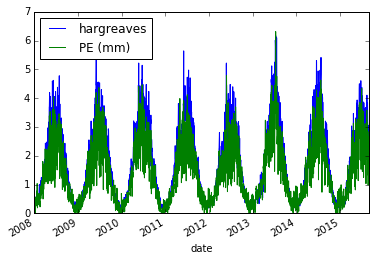

In [13]:
compare = df2.merge(metPE, on = 'date')
compare.head()
compare.plot(x='date')

Filter out unwanted columns (Model only needs temp, PE and rainfall)

In [14]:
df = df[['date','meantp','hargreaves','rain']]
df.head()

,date,meantp,hargreaves,rain
0,2007-01-01,4.8,0.203998,4.8
1,2007-01-02,7.1,0.307439,0.4
2,2007-01-03,10.1,0.324130,2.9
3,2007-01-04,8.5,0.238953,0.0
4,2007-01-05,7.4,0.350152,0.8


Convert 'date' column to datetime object so Pandas can use it 

Split data into seasons based on months

Winter = 1, Spring = 2, Summer = 3, Autumn = 4

In [15]:
#create a season function to split data into seasons
def get_season(row):
    if row['date'].month >= 3 and row['date'].month <= 5:
        return '2'
    elif row['date'].month >= 6 and row['date'].month <= 8:
        return '3'
    elif row['date'].month >= 9 and row['date'].month <= 11:
        return '4'
    else:
        return '1'

Apply the season function to the data

In [16]:
df['Season'] = df.apply(get_season, axis=1)

Create 'Year' column from the 'date' column

In [17]:
df['Year'] = df['date'].dt.year

Make December of previous year part of winter for current year (to keep climatolgical year) 

In [18]:
#Redefine the year to attach December of previous year to winter of following year 
#Everywhere the month is '12', the year column gets increased by 1. 
df.loc[df['date'].dt.month == 12, 'Year'] += 1
df.head()

,date,meantp,hargreaves,rain,Season,Year
0,2007-01-01,4.8,0.203998,4.8,1,2007
1,2007-01-02,7.1,0.307439,0.4,1,2007
2,2007-01-03,10.1,0.324130,2.9,1,2007
3,2007-01-04,8.5,0.238953,0.0,1,2007
4,2007-01-05,7.4,0.350152,0.8,1,2007


Create a new dataframe indexed by Year and Season

In [19]:
#how to multiindex from here: http://stackoverflow.com/questions/33435971/selecting-time-series-data-in-a-specific-sequence-using-pandas/33437422#33437422
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2.head()

date  meantp  hargreaves  rain
Year Season                                     
2007 1      2007-01-01     4.8    0.203998   4.8
     1      2007-01-02     7.1    0.307439   0.4
     1      2007-01-03    10.1    0.324130   2.9
     1      2007-01-04     8.5    0.238953   0.0
     1      2007-01-05     7.4    0.350152   0.8

# Remove incomplete seasons and apply missing value threshold
Count the values in each season (also indicates missing values)

Number of days in:
- 1 (Winter): 90 (91 in Leap Year - how to deal with this?) 
- 2 (Spring): 92
- 3 (Summer): 92
- 4 (Autumn): 91

In [20]:
count = df2.groupby(level=[0, 1]).count()
count

date  meantp  hargreaves  rain
Year Season                                
2007 1         59      59          59    59
     2         92      92          92    92
     3         92      92          92    90
     4         91      91          91    74
2008 1         91      91          91    86
     2         92      92          92    92
     3         92      92          92    91
     4         91      91          91    90
2009 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2010 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2011 1         90      90          90    90
     2         92      92          92    92
     3         92      91          91    91
     4         91      91          91    91
2012 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2013 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    89
     4         91      91          91    91
2014 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2015 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92

Create a 'complete' variable with only complete months of data (75 is completely arbitrary - code this in up top)

In [21]:
complete = count[count['rain'] >= 75].index #counts seasons with more than 75 values for rain

Create an index for the values in the dataframe which match the 'complete' index

In [22]:
idx = df2.index.isin(complete)
idx #first are false, as the first season (Winter 2007) does not have enough days in it (missing December 2006)

array([False, False, False, ...,  True,  True,  True], dtype=bool)

In [23]:
df = df[idx]
df

,date,meantp,hargreaves,rain,Season,Year
59,2007-03-01,5.7,1.062825,0.3,2,2007
60,2007-03-02,3.8,0.988286,16.9,2,2007
61,2007-03-03,7.0,1.187963,0.2,2,2007
62,2007-03-04,7.0,1.241618,10.0,2,2007
63,2007-03-05,6.5,1.163585,14.3,2,2007
64,2007-03-06,6.8,1.069878,5.5,2,2007
65,2007-03-07,6.0,1.206203,0.3,2,2007
66,2007-03-08,5.9,1.149655,4.0,2,2007
67,2007-03-09,7.4,1.281770,0.1,2,2007
68,2007-03-10,9.7,1.447036,0.0,2,2007


In [24]:
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2

date  meantp  hargreaves  rain
Year Season                                     
2007 2      2007-03-01     5.7    1.062825   0.3
     2      2007-03-02     3.8    0.988286  16.9
     2      2007-03-03     7.0    1.187963   0.2
     2      2007-03-04     7.0    1.241618  10.0
     2      2007-03-05     6.5    1.163585  14.3
     2      2007-03-06     6.8    1.069878   5.5
     2      2007-03-07     6.0    1.206203   0.3
     2      2007-03-08     5.9    1.149655   4.0
     2      2007-03-09     7.4    1.281770   0.1
     2      2007-03-10     9.7    1.447036   0.0
     2      2007-03-11     7.6    1.086091   7.3
     2      2007-03-12     7.9    1.363238   1.3
     2      2007-03-13     7.3    1.432536   0.1
     2      2007-03-14     8.2    1.655405   0.1
     2      2007-03-15     6.2    1.501943   0.1
     2      2007-03-16     5.0    1.413379   0.1
     2      2007-03-17    10.0    0.978895   0.2
     2      2007-03-18     5.0    1.341261   1.5
     2      2007-03-19     3.6    1.106303   2.9
     2      2007-03-20     3.6    1.148815   0.0
     2      2007-03-21     1.6    1.280704   2.4
     2      2007-03-22     8.5    1.264217   0.4
     2      2007-03-23     6.3    1.726442   0.0
     2      2007-03-24     6.8    1.867513   0.0
     2      2007-03-25     6.4    1.688401   0.0
     2      2007-03-26     7.0    1.909344   0.0
     2      2007-03-27     6.8    2.191774   0.0
     2      2007-03-28     6.6    1.598351   1.6
     2      2007-03-29     5.9    1.521981   2.5
     2      2007-03-30     7.1    1.304259   0.0
...                ...     ...         ...   ...
2015 3      2015-08-02    15.2    3.070193   8.6
     3      2015-08-03    15.4    2.941266   1.1
     3      2015-08-04    15.6    2.962541   0.5
     3      2015-08-05    14.2    2.394153  10.0
     3      2015-08-06    14.0    3.393655   0.4
     3      2015-08-07    13.7    3.289386   0.0
     3      2015-08-08    12.7    3.529534   0.4
     3      2015-08-09    17.2    2.935915   0.0
     3      2015-08-10    15.2    3.252137   0.1
     3      2015-08-11    15.0    2.753564   0.0
     3      2015-08-12    15.2    3.786022   0.0
     3      2015-08-13    15.6    4.105458   0.0
     3      2015-08-14    13.6    3.116571   0.7
     3      2015-08-15    11.5    3.056900   0.0
     3      2015-08-16    13.6    2.856747   0.0
     3      2015-08-17    16.6    3.030269   0.0
     3      2015-08-18    15.8    3.845087   0.0
     3      2015-08-19    16.6    3.016253   5.2
     3      2015-08-20    16.7    2.754104   0.1
     3      2015-08-21    17.4    3.069284   0.6
     3      2015-08-22    14.7    2.584863   6.0
     3      2015-08-23    13.6    1.398668  11.1
     3      2015-08-24    13.2    3.032389   0.0
     3      2015-08-25    12.5    2.706166  25.4
     3      2015-08-26    13.8    2.535701   4.6
     3      2015-08-27    13.8    2.810942   3.9
     3      2015-08-28    14.0    2.772288   1.1
     3      2015-08-29    15.0    2.816055   2.7
     3      2015-08-30    13.6    2.326787   0.1
     3      2015-08-31    15.0    2.405260   0.4

[3015 rows x 4 columns]

Print the entire dataframe to check it (can remove this section as it does it correctly)

In [25]:
with pd.option_context('display.max_rows', 999, 'display.max_columns', 6):
    print df

           date  meantp  hargreaves  rain Season  Year
59   2007-03-01     5.7    1.062825   0.3      2  2007
60   2007-03-02     3.8    0.988286  16.9      2  2007
61   2007-03-03     7.0    1.187963   0.2      2  2007
62   2007-03-04     7.0    1.241618  10.0      2  2007
63   2007-03-05     6.5    1.163585  14.3      2  2007
64   2007-03-06     6.8    1.069878   5.5      2  2007
65   2007-03-07     6.0    1.206203   0.3      2  2007
66   2007-03-08     5.9    1.149655   4.0      2  2007
67   2007-03-09     7.4    1.281770   0.1      2  2007
68   2007-03-10     9.7    1.447036   0.0      2  2007
69   2007-03-11     7.6    1.086091   7.3      2  2007
70   2007-03-12     7.9    1.363238   1.3      2  2007
71   2007-03-13     7.3    1.432536   0.1      2  2007
72   2007-03-14     8.2    1.655405   0.1      2  2007
73   2007-03-15     6.2    1.501943   0.1      2  2007
74   2007-03-16     5.0    1.413379   0.1      2  2007
75   2007-03-17    10.0    0.978895   0.2      2  2007
76   2007-

Calculate number of seasons in the dataset (to calculate seasonal rainfall means later)

In [26]:
seascount = df2.groupby(level=[0,1]).count() #counting number of seasons (to divide for avg seasonal rainfall later)
seascount

date  meantp  hargreaves  rain
Year Season                                
2007 2         92      92          92    92
     3         92      92          92    90
2008 1         91      91          91    86
     2         92      92          92    92
     3         92      92          92    91
     4         91      91          91    90
2009 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2010 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2011 1         90      90          90    90
     2         92      92          92    92
     3         92      91          91    91
     4         91      91          91    91
2012 1         91      91          91    91
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2013 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    89
     4         91      91          91    91
2014 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92
     4         91      91          91    91
2015 1         90      90          90    90
     2         92      92          92    92
     3         92      92          92    92

In [27]:
seasoncount = df.reset_index().groupby('Season')['Year'].nunique()
print seasoncount

Season
1    8
2    9
3    9
4    7
Name: Year, dtype: int64


# Temperature Extremes

Calculate mean values for each season

In [28]:
seasmean = df['meantp'].groupby(df['Season']).mean()
print seasmean #check the averages - do they seem correct? Yes

Season
1     4.795568
2     8.845411
3    14.850544
4    10.382732
Name: meantp, dtype: float64


Calculating differences between season and season means & adding a zscore column

In [29]:
df2['seasdif'] = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates an anomaly column
seasdif = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean #creates a series

df2['tempzscore'] = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std() #calculates z-scores
tempzscore = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std() #series

print seasdif
print df2.head()

Year  Season
2007  2         0.883937
      3        -0.120109
2008  1         1.298938
      2         0.016546
      3        -0.083153
      4        -0.848666
2009  1        -0.448901
      2         0.174155
      3         0.121195
      4         0.250235
2010  1        -2.391123
      2        -0.442150
      3         0.436412
      4        -0.716797
2011  1        -1.755568
      2         0.729589
      3        -1.162632
      4         1.437049
2012  1         1.635201
      2        -0.054106
      3        -0.245109
      4        -1.199215
2013  1         0.314432
      2        -1.618237
      3         1.232065
      4         0.481005
2014  1         1.128877
      2         0.794807
      3         0.455978
      4         0.596389
2015  1         0.185543
      2        -0.484541
      3        -0.647283
Name: meantp, dtype: float64
                  date  meantp  hargreaves  rain   seasdif  tempzscore
Year Season                                                   

Visualise the seasonal differences (illustrative only - to get an idea of variation)

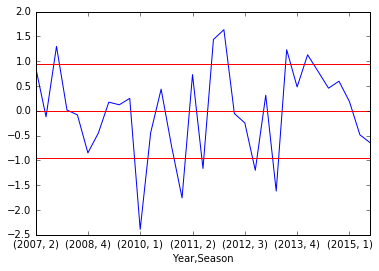

In [30]:
#visualise the seasonal differences (calculate greater than 2 standard deviations?)
seasdif.plot()
plt.axhline(0,color='red')
plt.axhline(seasdif.std() * 1, color ='red')
plt.axhline(-(seasdif.std()) * 1, color ='red')

### Z score comparison

Plot the Z-Score column (two different ways, to see if both methods did the same thing)

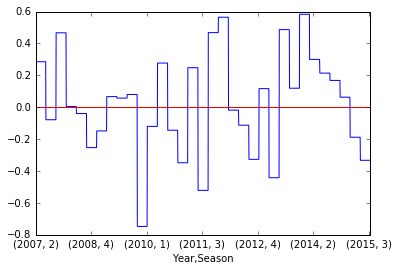

In [31]:
df2['tempzscore'].plot()
plt.axhline(0, color ='red')

In [32]:
seaszscore = (df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean) / df2['meantp'].groupby(level=['Year','Season']).std()
seaszscore

Year  Season
2007  2         0.285487
      3        -0.078255
2008  1         0.466904
      2         0.004817
      3        -0.039394
      4        -0.253130
2009  1        -0.148388
      2         0.066754
      3         0.057498
      4         0.080213
2010  1        -0.747489
      2        -0.119875
      3         0.277255
      4        -0.144012
2011  1        -0.348149
      2         0.247973
      3        -0.521351
      4         0.468077
2012  1         0.564761
      2        -0.017981
      3        -0.112629
      4        -0.326642
2013  1         0.116867
      2        -0.442007
      3         0.487095
      4         0.119518
2014  1         0.583180
      2         0.300093
      3         0.214225
      4         0.168300
2015  1         0.063110
      2        -0.187967
      3        -0.332652
Name: meantp, dtype: float64

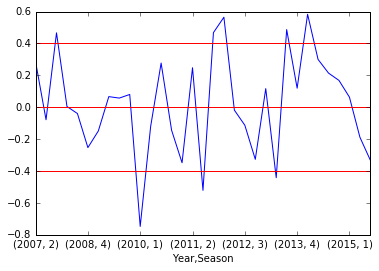

In [33]:
seaszscore.plot()
plt.axhline(0,color='red')
plt.axhline(0.4, color ='red')
plt.axhline(-0.4, color ='red')

# Rainfall Extremes

Calculate sum values for each season

In [34]:
rainsum = df['rain'].groupby(df['Season']).sum() / seasoncount #seasonal sums divided by number of years to get baseline rainfall
print rainsum #checked this in Excel, the division is correct

Season
1    223.487500
2    153.155556
3    248.788889
4    267.100000
dtype: float64


In [35]:
raindif = df2['rain'].groupby(level=['Year','Season']).sum() - rainsum #work out the anomalies
raindif

Year  Season
2007  2         -26.355556
      3          85.611111
2008  1          14.712500
      2          -0.355556
      3         117.111111
      4         -51.200000
2009  1         -33.087500
      2          50.844444
      3          69.911111
      4         118.100000
2010  1         -30.287500
      2          27.944444
      3         -91.988889
      4          -1.800000
2011  1           1.212500
      2         -66.955556
      3        -104.188889
      4           9.900000
2012  1         -72.687500
      2         -28.655556
      3         117.711111
      4         -84.900000
2013  1         -43.387500
      2         -15.555556
      3         -97.288889
      4         -45.000000
2014  1         237.012500
      2          43.044444
      3         -40.188889
      4          54.900000
2015  1         -73.487500
      2          16.044444
      3         -56.688889
dtype: float64

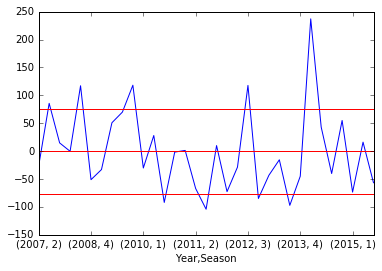

In [36]:
#visualise the seasonal differences - does this method make sense?
raindif.plot()
plt.axhline(0,color='red')
plt.axhline(raindif.std() * 1, color ='red')
plt.axhline(-(raindif.std()) * 1, color ='red')

# Extracting extreme seasons

Create a copy of the dataframe and two blank lists for hot and cold extremes

In [37]:
seasdif2 = pd.DataFrame(seasdif)
warm = []
cold = []

Create a function which identifies warm and cold extremes based on the data

Currently uses 1 standard deviation as the threshold, could use a z-score?

In [38]:
def extremetemp(x):
    for season in x:
        if season > x.std() * 1:
            warm.append(1)
        else:
            warm.append(0)

    for season in x:
        if season < (-(x.std()*1)):
            cold.append(1)
        else:
            cold.append(0)

Apply the function to the dataset

In [39]:
extremetemp(seasdif)

Create new columns in duplicate dataset to identify which season has an extreme value

In [40]:
seasdif2['cold']=cold
seasdif2['warm']=warm
seasdif2

meantp  cold  warm
Year Season                      
2007 2       0.883937     0     0
     3      -0.120109     0     0
2008 1       1.298938     0     1
     2       0.016546     0     0
     3      -0.083153     0     0
     4      -0.848666     0     0
2009 1      -0.448901     0     0
     2       0.174155     0     0
     3       0.121195     0     0
     4       0.250235     0     0
2010 1      -2.391123     1     0
     2      -0.442150     0     0
     3       0.436412     0     0
     4      -0.716797     0     0
2011 1      -1.755568     1     0
     2       0.729589     0     0
     3      -1.162632     1     0
     4       1.437049     0     1
2012 1       1.635201     0     1
     2      -0.054106     0     0
     3      -0.245109     0     0
     4      -1.199215     1     0
2013 1       0.314432     0     0
     2      -1.618237     1     0
     3       1.232065     0     1
     4       0.481005     0     0
2014 1       1.128877     0     1
     2       0.794807     0     0
     3       0.455978     0     0
     4       0.596389     0     0
2015 1       0.185543     0     0
     2      -0.484541     0     0
     3      -0.647283     0     0

### Do the same for Rainfall

In [41]:
raindif2 = pd.DataFrame(raindif)
wet = []
dry = []

Create a function which identifies wet and dry extremes based on the data

In [42]:
def extremerain(x):
    for season in x:
        if season > x.std() * 1:
            wet.append(1)
        else:
            wet.append(0)

    for season in x:
        if season < (-(x.std()*1)):
            dry.append(1)
        else:
            dry.append(0)

Apply the function to the dataset

In [43]:
extremerain(raindif)

In [44]:
seasdif2['wet']=wet
seasdif2['dry']=dry
seasdif2

meantp  cold  warm  wet  dry
Year Season                                
2007 2       0.883937     0     0    0    0
     3      -0.120109     0     0    1    0
2008 1       1.298938     0     1    0    0
     2       0.016546     0     0    0    0
     3      -0.083153     0     0    1    0
     4      -0.848666     0     0    0    0
2009 1      -0.448901     0     0    0    0
     2       0.174155     0     0    0    0
     3       0.121195     0     0    0    0
     4       0.250235     0     0    1    0
2010 1      -2.391123     1     0    0    0
     2      -0.442150     0     0    0    0
     3       0.436412     0     0    0    1
     4      -0.716797     0     0    0    0
2011 1      -1.755568     1     0    0    0
     2       0.729589     0     0    0    0
     3      -1.162632     1     0    0    1
     4       1.437049     0     1    0    0
2012 1       1.635201     0     1    0    0
     2      -0.054106     0     0    0    0
     3      -0.245109     0     0    1    0
     4      -1.199215     1     0    0    1
2013 1       0.314432     0     0    0    0
     2      -1.618237     1     0    0    0
     3       1.232065     0     1    0    1
     4       0.481005     0     0    0    0
2014 1       1.128877     0     1    1    0
     2       0.794807     0     0    0    0
     3       0.455978     0     0    0    0
     4       0.596389     0     0    0    0
2015 1       0.185543     0     0    0    0
     2      -0.484541     0     0    0    0
     3      -0.647283     0     0    0    0

### Select out combinations of extremes (warm/wet, warm/dry, cold/wet, cold/dry)

In [45]:
#identify columns with cold extremes (could do the same for warm but there are none)
seasdif2.loc[(seasdif2.cold==1) | (seasdif2.dry==1) | (seasdif2.warm==1) | (seasdif2.wet ==1)]

meantp  cold  warm  wet  dry
Year Season                                
2007 3      -0.120109     0     0    1    0
2008 1       1.298938     0     1    0    0
     3      -0.083153     0     0    1    0
2009 4       0.250235     0     0    1    0
2010 1      -2.391123     1     0    0    0
     3       0.436412     0     0    0    1
2011 1      -1.755568     1     0    0    0
     3      -1.162632     1     0    0    1
     4       1.437049     0     1    0    0
2012 1       1.635201     0     1    0    0
     3      -0.245109     0     0    1    0
     4      -1.199215     1     0    0    1
2013 2      -1.618237     1     0    0    0
     3       1.232065     0     1    0    1
2014 1       1.128877     0     1    1    0

warm/wet

In [46]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.wet ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
2014,1,1.128877,0,1,1,0


warm/dry

In [47]:
seasdif2.loc[(seasdif2.warm==1) & (seasdif2.dry ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
2013,3,1.232065,0,1,0,1


cold/dry

In [48]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.dry==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,
2011,3,-1.162632,1,0,0,1
2012,4,-1.199215,1,0,0,1


cold/wet

In [49]:
seasdif2.loc[(seasdif2.cold==1) & (seasdif2.wet ==1)]

,,meantp,cold,warm,wet,dry
Year,Season,,,,,


### Resample the data and create a new seqence

In [50]:
#blank dataframe
future = pd.DataFrame()

In [51]:
df2.head()

date  meantp  hargreaves  rain   seasdif  tempzscore
Year Season                                                           
2007 2      2007-03-01     5.7    1.062825   0.3  0.883937    0.285487
     2      2007-03-02     3.8    0.988286  16.9  0.883937    0.285487
     2      2007-03-03     7.0    1.187963   0.2  0.883937    0.285487
     2      2007-03-04     7.0    1.241618  10.0  0.883937    0.285487
     2      2007-03-05     6.5    1.163585  14.3  0.883937    0.285487

In [52]:
df3 = df2[['meantp','hargreaves','rain']]
df3.head()

meantp  hargreaves  rain
Year Season                          
2007 2          5.7    1.062825   0.3
     2          3.8    0.988286  16.9
     2          7.0    1.187963   0.2
     2          7.0    1.241618  10.0
     2          6.5    1.163585  14.3

Loop through for x amount of years 

PROBLEM: This only works when seasons 2 and 3 are included, doesn't work when 1 and 4 are included, maybe because 1 and 4 are not in the year 2007

PROBLEM 2: Even if it works - this doesn't do what I want it to, I want to be able to select a sequence with 5 normal seasons followed by 5 hot/dry summers or 10 cold/wet winters etc

In [53]:
for i in range(outputyears):
    for season in ['1', '2', '3','4']:
        future = future.append(df3.loc[np.random.choice(range(startyear, endyear))]
                                  .loc[season])

KeyError: 'the label [1] is not in the [index]'

In [54]:
future.head()
future

,meantp,hargreaves,rain
Season,,,
1,5.4,0.330160,4.3
1,8.6,0.404655,NaN
1,7.0,0.324525,0.4
1,10.7,0.468998,3.9
1,10.4,0.372448,6.9
1,11.4,0.467635,24.0
1,5.8,0.386696,2.5
1,7.4,0.450693,15.4
1,6.2,0.262941,3.4


### Change the output directory and save the file

In [ ]:
#check spacing replace with underscore
os.chdir('E:\PhD\Data\Block Resampling')
#save the file
future.to_csv('future.csv', sep = ',')